# Lab 6 - Information theory

This lab has a few goals designed to get you comfortable with working with python and playing with the basiscs of information theory.

Sections:
1. Entropy
2. Mutual information
3. KL divergence

## Background

For this lab we won't be working with our main library, _explorationlib_. We'll use a few standard libraries to both get more comfortable with python and to refresh the concepts of information theory discussed in class.

### **What is entropy?**

- According to Shannon's definition, the entropy $H(X)$ of a discrete random variable is: $H(X)= \sum_{x \in X} p(x) \log _2 p(x)^{-1}$.
- Here we are assuming that the discrete variable is binary, hence the use of $\log _2$
- A key aspect of the definition entropy is the 'surprise' termn, $p(x)^{-1}$. The more surprising an outcome is, the more valuable that bit of information is. We will return to this later in class.

### **Entropy between variables**

- The _joint entropy_ between two discrete random variables, $X$ and $Y$, is just an expansion of the regular concept of entropy: $H(X, Y)= \sum_{x \in X} p(x,y) \log _2 p(x,y)^{-1}$.
- Note that in here, $p(x,y)$ is the joint probability distribution between the variables.
- Expanding out from the rules of conditional probabilities (thank you Mr. Bayes), the joint entropy can be expanded as the product of the entropy of the primary variable and the conditional entropy of the two variables: $H(X,Y) = H(X) + H(Y|X)$. _Pay attention to the ordering of terms, it gets important later_.

### **Mutual information between variables**.

- Sticking with the idea of joint entropy, the _conditional entropy_ $H(X|Y)$ reflects the residual entropy of $X$ after you have knowledge about $Y$. This is expressed as: $H(X|Y)=H(X)-I(X;Y)$.
- We call this second term, $I(X;Y)$ the _mutual information_ between $X$ and $Y$. It is the information provided by Y about X. If you were in statistics and working with continuous variables, this would be the correlation (or covariance).
- We can rewrite the equation above as $I(X;Y) = H(X) - H(X|Y) = \sum_{x \in X, y \in Y} p(x,y) \log _2 \frac{p(x,y)}{p(x)p(y)}$

### **Kullback-Leibler (KL) divergence**.

- Often referred to as relative entropy, this is a measure of how one probability distribution diverges from a second, reference probability distribution. It quantifies the amount of information lost when approximating one distribution with another.

- Consider $P(X)$ and $Q(X)$ to be two probability distribtions of a random variable. In our example, spike trains from two neurons.

- The KL divergence of $P$ and $Q$, $D_{KL}(P||Q)$, is defined as

$$D_{KL}(P||Q)=\Sigma_{x \in X} p(x)\log_2 (\frac{p(x)}{q(x)})$$

- Essentially $D_{KL}(P||Q)$ is a measure of the distance between two distributions

## Section 0 - Setup

For today's lab we'll start simple. All we need is _numpy_ and _matplotlib_ (for plotting)

In [ ]:
# Import the general libraries we will be using
import numpy as np
import matplotlib.pyplot as plt

## Section 1 - Entropy

- For this section we will simulate two cells, a presynaptic and postsynaptic cell. The data will consist of spikes. We will vary the degree of dependency between the neurons and look at their relative entropies.
- One way to achieve this is to use a Poisson process to simulate the neurons. Here, the firing of each neuron at each time step is modeled as a binary event that occurs with some probability. The influence of the first neuron on the second is represented by increasing the firing probability of the second neuron when the first one fires.

In [ ]:
def simulate_neuron_spikes(n_samples, base_firing_prob, influence, noise_level, neuron1=None):
    """
    Simulate the spiking of a neuron.

    If neuron1 is not None, then this neuron is influenced by neuron1.
    """
    spikes = np.zeros(n_samples)

    for i in range(n_samples):
        firing_prob = base_firing_prob

        if neuron1 is not None and neuron1[i] == 1:
            firing_prob += influence

        firing_prob += noise_level * np.random.randn()

        if np.random.uniform(low=0.0, high=1.0) < firing_prob:
            spikes[i] = 1

    return spikes



In [ ]:
# Time and rates
total_time_sec = 5
sampling_rate_hz = 1000
n_samples = total_time_sec * sampling_rate_hz

# Probabilities
base_firing_prob = 0.02
influence = 0.3
noise_level = 0.01

# Simulate the two neurons
neuron1 = simulate_neuron_spikes(n_samples, base_firing_prob, 0, noise_level)
neuron2 = simulate_neuron_spikes(n_samples, base_firing_prob, influence, noise_level, neuron1)

print("Neuron 1 spike train:", neuron1)
print("Neuron 2 spike train:", neuron2)

Neuron 1 spike train: [0. 0. 0. ... 0. 0. 0.]
Neuron 2 spike train: [0. 0. 0. ... 0. 0. 0.]


What we have created are two binary vectors, _neuron1_ and _neuron2_, that represent the spike trains of two neurons over 5 seconds at a 1 kHz sampling rate.

Each time step is a binary event where 1 represents a spike and 0 represents no spike. The base firing probability is 2%, but this is modified by two factors: the influence of the first neuron on the second, and some independent noise.

The _influence_ parameter controls how much the first neuron affects the second: whenever the first neuron fires, the firing probability of the second neuron is increased by the influence factor. The _noise level_ parameter controls the amount of independent noise in the firing probabilities. This noise is modeled as Gaussian noise and is independent for each neuron and each time step.

### Visualizing our two neurons

We can use a raster plot to visualize the spike times of our neurons. For this we will use matplotlib.

In a raster plot, each row corresponds to a different repetition of the experiment (a different neuron in this case), and the x-axis represents time. Each small vertical line (marker) represents a spike.

In [ ]:
def plot_spikes(neuron1, neuron2, sampling_rate_hz):
    """
    Plot the spikes of the two neurons as a raster plot.
    """
    time_points = np.arange(len(neuron1)) / sampling_rate_hz

    fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True, sharey=True)

    # Neuron 1
    ax[0].eventplot(time_points[neuron1 == 1], color='black')
    ax[0].set_title("Neuron 1")
    ax[0].set_ylabel("Spikes")

    # Neuron 2
    ax[1].eventplot(time_points[neuron2 == 1], color='black')
    ax[1].set_title("Neuron 2")
    ax[1].set_ylabel("Spikes")
    ax[1].set_xlabel("Time (sec)")

    plt.tight_layout()
    plt.show()


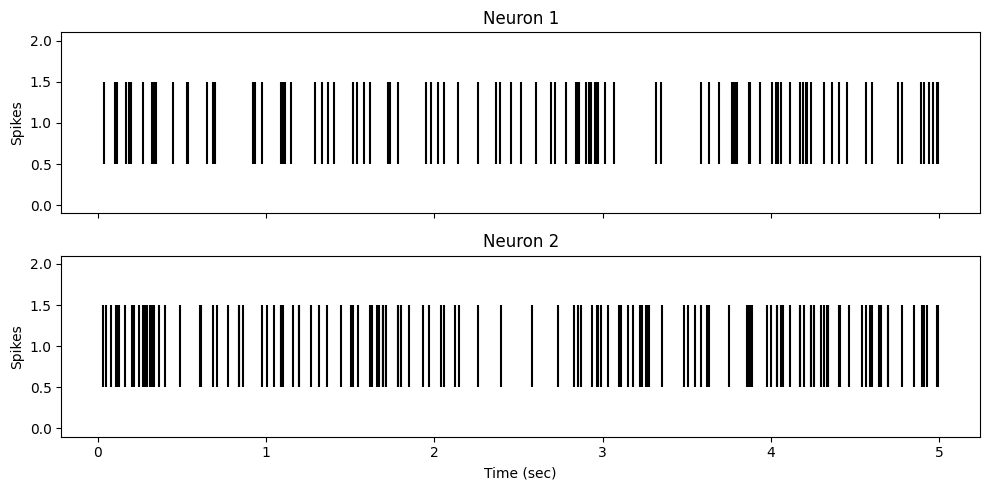

In [ ]:
# Run the plotting function
plot_spikes(neuron1, neuron2, sampling_rate_hz)

Let's now calculate the entropy of each neuron. For this we will use a simple function that follows the equations for entropy in the Background and the reading.

In [ ]:
def calculate_entropy(neuron):
    """
    Calculate the entropy of the spike train of a neuron.
    """
    # Count the number of 0s and 1s in the array
    unique, counts = np.unique(neuron, return_counts=True)
    probs = counts / len(neuron)

    # Calculate the entropy
    entropy = -np.sum(probs * np.log2(probs))
    return entropy

Now let's see how our neurons are doing.

In [ ]:
# Calculate and print the entropies
entropy_neuron1 = calculate_entropy(neuron1)
entropy_neuron2 = calculate_entropy(neuron2)

print(f"Entropy of Neuron 1: {entropy_neuron1}")
print(f"Entropy of Neuron 2: {entropy_neuron2}")


Entropy of Neuron 1: 0.13578841288558574
Entropy of Neuron 2: 0.1770433412634236


---
### Question 1.1

Increase the baseline firing rate parameter, *base_firing_prob*, by a factor of 10 to 0.2. What happens to the entropies of the neurons? Explain why this effect may or may not occur.

__Answer:__
Entropies increase from 0.14 to 0.7.
Uncertainty went up becasue baseline firing rate went up.

---
### Question 1.2

Put the baseline firing rate parameter back to 0.02. Increase the influence parameter, from neuron 1 to neuron 2, by a factor of 10 to 0.3. What happens to the entropies of the neurons? Explain why this effect may or may not occur.

__Answer:__

The entropy of neuron 2 increased by a small amount. You're incresing the chance that neuron 2 spikes by 30% when increasing the influence parameter. Info is getting carried from neuron 1 to neuron 2 and uncertainty for neuron 2 goes up since its relaying info from external source/neuron 1.

## Section 2 - Mutual information

We have our two happy little neurons firing. We've played with the parameters to see how it impacts their relative entropy. Now let's go back to the original parameter settings and see about estimating the mutual information between our neurons.

Recall that to estimate the mutual information, we need to estimate the conditional entropy for $X$ on $Y$. For binary variables things are a bit easier because $H(X|Y) = H(Y) - H(X,Y)$. Which means we only need to get both independnet entropies and the joint entropy. This leaves us with this simple and beautiful equation: $I(X; Y) = H(X) + H(Y) - H(X, Y)$.

We can easily write a function to do this. First we start with esimating the joint entropy of the two variables.

$$ H(X,Y) = -\Sigma_{x,y}P(X=x,Y=y)\log_2 P(X=x, Y=y) $$

In [ ]:
def calculate_joint_entropy(neuron1, neuron2):
    # Calculate joint probability distribution
    joint_prob, _, _ = np.histogram2d(neuron1, neuron2, bins=2, range=[[0, 1], [0, 1]])
    joint_prob /= len(neuron1)

    # Calculate joint entropy
    joint_entropy = -np.sum(joint_prob * np.log2(joint_prob + np.finfo(float).eps))

    return joint_entropy

Let's take a moment to take a look at this central estimate of the joint firing probabilities. We'll pull this out of the function and probe here.

In [ ]:
joint_prob, _, _ = np.histogram2d(neuron1, neuron2, bins=2, range=[[0, 1], [0, 1]])
joint_prob /= len(neuron1)
print(f"{joint_prob}")

[[0.9598 0.0212]
 [0.0136 0.0054]]


Most of the time, both neurons are 0 (upper left value). A small percentage of the time one neuron fires when the other does not (off diagonal entries). Finally, a small percentage of the time both neurons fire together (lower right).

Now we can calculate the full mutual information by subtracting this joint entropy from the relative entropy of the two variables.

In [ ]:
def calculate_mutual_information(neuron1, neuron2):
    """
    Calculate the mutual information between the spike trains of two neurons.
    """
    entropy_neuron1 = calculate_entropy(neuron1)
    entropy_neuron2 = calculate_entropy(neuron2)
    joint_entropy = calculate_joint_entropy(neuron1, neuron2)

    # Use the formula for mutual information
    mutual_information = entropy_neuron1 + entropy_neuron2 - joint_entropy

    return mutual_information


So let's see what the mutal information is when we re-simulate our neurons back at the original parameter settings.

In [ ]:
# Time and rates
total_time_sec = 5
sampling_rate_hz = 1000
n_samples = total_time_sec * sampling_rate_hz

# Probabilities
base_firing_prob = 0.02
influence = 0.3
noise_level = 0.01

# Simulate the two neurons
neuron1 = simulate_neuron_spikes(n_samples, base_firing_prob, 0, noise_level)
neuron2 = simulate_neuron_spikes(n_samples, base_firing_prob, influence, noise_level, neuron1)

# Calculate and print the mutual information
mutual_information = calculate_mutual_information(neuron1, neuron2)
print(f"Mutual Information: {mutual_information}")

Mutual Information: 0.01683320534653987


This reflects the mutual dependence between the two neurons. You can probably guess what questions we will ask about this.

---
### Question 2.1

Increase the baseline firing rate parameter, *base_firing_prob*, by a factor of 10 to 0.2. What happens to the mutual information of the neurons? Explain why this effect may or may not occur.

__Answer:__

The mututal information of the neurons increased. This is because state 1 is conveying information to state 2. By increasing base firing rate, you are giving more opportunities for neuron 1 to convey info to neuron 2 (increase probability of info being conveyed).

---
### Question 2.2

Put the baseline firing rate parameter back to 0.02. Increase the influence parameter, from neuron 1 to neuron 2, by a factor of 10 to 0.3. What happens to the mutual information of the neurons? Explain why this effect may or may not occur.

__Answer:__

Mutual information increases when we increase influence parameter, so we are more likely to see neuron 2 spike when neuron 1 spikes.

---
### Question 2.3

Take the last set of simulations that you ran (with the influence set at 0.3) and switch the order of the neurons in the calculation of mutual information. What does or does not happen to the mutual information estimate? Why?

__Answer:__

The mutual information halved. This can be because when we flip the order, we get a lower degree of information conveyed, neuron 2 can be on but neuron 1 could be 0.


## Section 3 - KL divergence

We can now move on to our information measure of interest, the KL divergence, $D_{KL}(P||Q)$. Let's start by setting up our neurons so that the first, presynaptic neuron has a strong influence on the spiking probability of the second, postsynaptic neuron.

For this we will make a strong synaptic connection by changing the *influence* parameter to 0.99, which means that when neuron1 spikes, neuron2's firing probability increases by 99%.

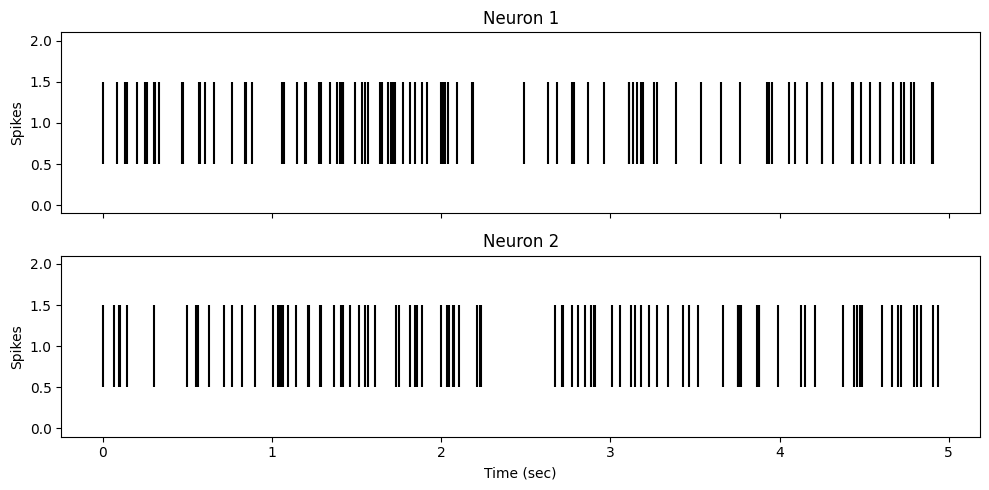

In [ ]:
# Time and rates
total_time_sec = 5
sampling_rate_hz = 1000
n_samples = total_time_sec * sampling_rate_hz

# Probabilities
base_firing_prob = 0.02
influence = 0.03           # when neuron 1 spikes, 99% chance neuron 2 also spikes
noise_level = 0.01

# Simulate the two neurons
neuron1 = simulate_neuron_spikes(n_samples, base_firing_prob, 0, noise_level)
neuron2 = simulate_neuron_spikes(n_samples, base_firing_prob, influence, noise_level, neuron1)

# Plot
plot_spikes(neuron1, neuron2, sampling_rate_hz)

Now let's write a simple function to calculate the KL divergence.

In [ ]:
def calculate_kl_divergence(neuron1, neuron2):
    # Calculate probability distributions
    unique, counts = np.unique(neuron1, return_counts=True)
    p1 = counts / len(neuron1)

    unique, counts = np.unique(neuron2, return_counts=True)
    p2 = counts / len(neuron2)

    # Avoid division by zero and log(0) by adding a small constant
    epsilon = np.finfo(float).eps
    p1 = np.clip(p1, epsilon, 1)
    p2 = np.clip(p2, epsilon, 1)

    # Calculate KL divergence
    kl_div = np.sum(p1 * np.log2(p1 / p2))

    return kl_div

Using the spiking data above, we get the following

In [ ]:
kl_div_value = calculate_kl_divergence(neuron1, neuron2)
print(f"KL Divergence: {kl_div_value}")


KL Divergence: 1.527037002596761e-06


Just to prove to you that KL divergence measures similarity in distributions, let's make two completely independent neurons and look at their KL divergence score.

In [ ]:
# Simulate the two neurons
neuron3 = simulate_neuron_spikes(n_samples, base_firing_prob, 0, noise_level)

kl_div_value = calculate_kl_divergence(neuron1, neuron3)
print(f"KL Divergence: {kl_div_value}")

KL Divergence: 9.214339551969711e-05


---
### Question 3.1

What does it mean that the KL diverence is higher for our connected neurons (neuron1, neuron2) than our unconnected neurons (neuron1, neuron3)

__Answer:__

This means that they are different. As a result of their causal relationship, their probability structures are diverging. The KL divergence is higher because the two neurons are more dependent on each other. The influence of the other neuron (3) is an additional source of information so their KL divergence will increase becuase it is changing. However, since neurons 1 and 3 aren't connected, their KL divergence would naturally be lower becuase there is less information flow/dependency between them. When 2 neurons are connected, entropy will increase for downstream neuron as uncertainty of upstream neuron increase.


---
### Question 3.2

Go back to our connected neurons (neuron1 & neuron2) and change the *influence* parameter back to 0.03. How does the KL divergence change? Explain why this effect may or may not occur.

__Answer:__

KL divergence decreased because entropy went down and we kept the same probability structure.

## Section 4 - Putting it together

Now let's simulate a set of experiments were we systematically increase the *influence* parameter and see how our three measures change.

In [ ]:
# Time and rates
total_time_sec = 5
sampling_rate_hz = 1000
n_samples = total_time_sec * sampling_rate_hz

# Probabilities
base_firing_prob = 0.02
noise_level = 0.01

# Influence parameters
influences = [0.01, 0.1, 0.5, 0.75, 0.99]

# For plotting
names = influences

e1 = []
e2 = []
mi = []
kl = []

for influence in influences:
  neuron1 = simulate_neuron_spikes(n_samples, base_firing_prob, 0, noise_level)
  neuron2 = simulate_neuron_spikes(n_samples, base_firing_prob, influence, noise_level, neuron1)

  e1.append(calculate_entropy(neuron1))
  e2.append(calculate_entropy(neuron2))
  mi.append(calculate_mutual_information(neuron2, neuron1))
  kl.append(calculate_kl_divergence(neuron2, neuron1))


First let's look at the relative entropies of the two neurons.

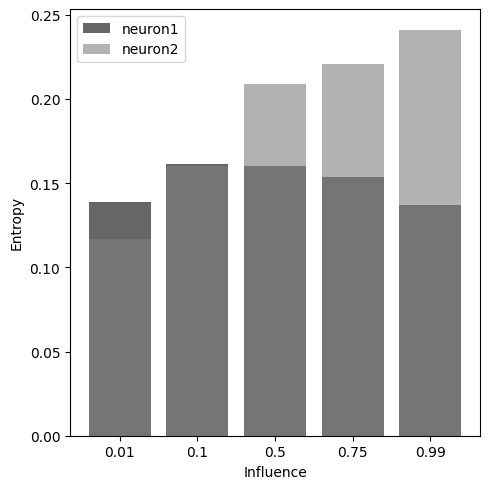

In [ ]:
# Now let's plot the entropies first
fig = plt.figure(figsize=(5, 5))
plt.bar([str(n) for n in names], e1, color="black", alpha=0.6, label="neuron1")
plt.bar([str(n) for n in names], e2, color="grey", alpha=0.6, label="neuron2")
plt.ylabel("Entropy")
plt.xlabel("Influence")
plt.tight_layout()
plt.legend()

---
### Question 4.1

What do you notice about the relative entropies of the two neurons?

__Answer:__

Neuron 1 entropy stays about the same as we increase influence. Neuron 2 entropy increases as we increase influence. Neuron 2 always has higher entropy because it is the post synaptic neuron, even at low influence level.

Next let's look at the mutual information.

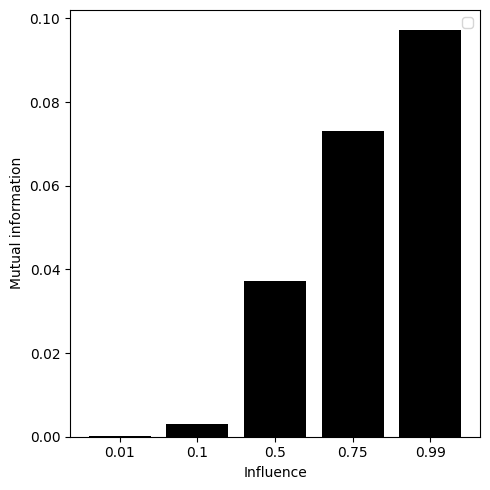

In [ ]:
# Now let's plot the mutual information
fig = plt.figure(figsize=(5, 5))
plt.bar([str(n) for n in names], mi, color="black")
plt.ylabel("Mutual information")
plt.xlabel("Influence")
plt.tight_layout()
plt.legend()

---
### Question 4.2

What does the mutual information do as you increase the presynaptic influence on the postsynaptic cell? Why does this occur?

__Answer:__
Mutual information increases as we increase presynaptic influence on the post synaptic cell. As we increase amount of influence that neuron 1 has on neuron 2, they become more correlated.



Finally, let's look at the KL divergence.

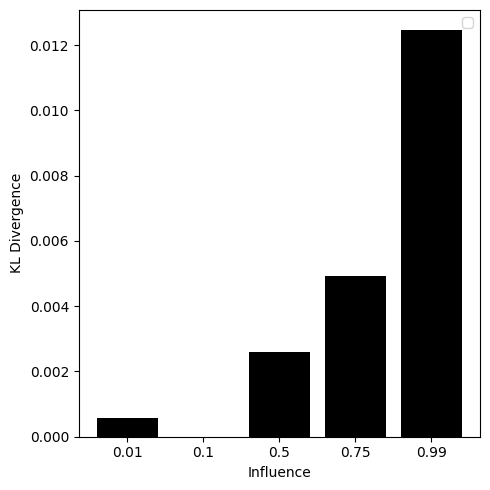

In [ ]:
# Finally KL divergence
fig = plt.figure(figsize=(5, 5))
plt.bar([str(n) for n in names], kl, color="black")
plt.ylabel("KL Divergence")
plt.xlabel("Influence")
plt.tight_layout()
plt.legend()

---
### Question 4.3

What does the KL divergence do as you increase the presynaptic influence on the postsynaptic cell? Why does this occur?

__Answer:__

KL divergence will increase. This occurs because the post synaptic neuron is changing because there is more input from the presynaptic neuron. This makes it diverge more from what it was originally.

---
### Question 4.4

Put all three results together and in simple English, explain what is happening the properties of both neurons as you increase the influence parameter.

__Answer:__

Increase
Neuron 1 doesn't change unless you change baseline firing rate.
The increases in entropy in Neuron 2 is being driven by information being moved from neuron 1 to neuron 2. This is because neuron 2 is responding to the influence of neuron 1 as the post synaptic neuron, so it has higher entropy.The mutual information between the neuron 1 and neuron 2 also increases as the influence parameter increases. This means that neuron 1 is conveying more information to neuron 2. KL divergence also increases as influence increases and this is because neuron 2 is changing because of the increased influence from neuron 1, causing their overall behavior to diverge more than if they were 2 independent/unconnected neurons.


---
**IMPORTANT** Did you collaborate with anyone on this assignment, or use LLMs like ChatGPT? If so, list their names here.
> *Write Name(s) here*